# Regresi Linear Sederhana: Prediksi "Quality Rating" dari "Benchmark MMLU"

Ringkasan langkah:
- Muat data `llm_comparison_dataset.csv`.
- Bersihkan ringan: hapus duplikat, ubah kolom ke numerik bila bisa, isi nilai hilang dengan median.
- Gunakan satu fitur prediktor: `Benchmark MMLU`.
- Jalankan regresi linear sederhana untuk memprediksi target `Quality Rating`.
- Tampilkan dan simpan metrik (MSE, RMSE, R²) dan plot garis regresi.
- Lakukan tes singkat untuk memastikan hasil wajar.
- Simpan ringkasan korelasi dan dataset bersih ke folder `outputs/`.


In [3]:
# Setup
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

sns.set_theme(style='whitegrid')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Paths (gunakan direktori kerja notebook)
DATA_PATH = Path('llm_comparison_dataset.csv')
OUTPUT_DIR = Path('outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f'Working directory: {os.getcwd()}')
print(f'Data path: {DATA_PATH.resolve()}')
print(f'Data exists: {DATA_PATH.exists()}')


Working directory: D:\KULIAH\SEMESTER 3\EXPLORATORY DATA ANALYSIS\UAS
Data path: D:\KULIAH\SEMESTER 3\EXPLORATORY DATA ANALYSIS\UAS\llm_comparison_dataset.csv
Data exists: True


## Muat & Bersihkan Data (Sederhana)

Penjelasan singkat:
- Hapus baris duplikat agar analisis tidak bias.
- Ubah kolom bertipe teks menjadi numerik jika memungkinkan (nilai yang tidak bisa akan menjadi NaN).
- Isi nilai hilang (NaN) pada kolom numerik dengan median kolom tersebut agar model tetap dapat dilatih.


In [4]:
assert DATA_PATH.exists(), f'Data file not found: {DATA_PATH}'
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()

# Hapus duplikat
before = len(df)
df = df.drop_duplicates().copy()
print(f'Removed {before - len(df)} duplicate rows. New shape: {df.shape}')

# Tentukan target dan fitur
y_col = 'Quality Rating'
x_col = 'Benchmark (MMLU)'
for required_col in [y_col, x_col]:
    if required_col not in df.columns:
        raise ValueError(f'Required column not found: {required_col}')

# Ubah semua kolom ke numerik bila memungkinkan
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Isi nilai hilang (median) untuk semua kolom numerik
numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
for col in numeric_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

# Validasi target & fitur
if not pd.api.types.is_numeric_dtype(df[y_col]):
    raise ValueError(f'Target {y_col} is not numeric after cleaning.')
if not pd.api.types.is_numeric_dtype(df[x_col]):
    raise ValueError(f'Predictor {x_col} is not numeric after cleaning.')


Removed 0 duplicate rows. New shape: (200, 15)


## Korelasi antara "Benchmark MMLU" dan "Quality Rating"

Menghitung korelasi Pearson untuk memahami kekuatan hubungan linear antara prediktor dan target. Juga menyimpan ringkasan korelasi untuk semua fitur numerik terhadap target.


In [5]:
# Korelasi kandidat utama
corr_val = df[[x_col, y_col]].corr().loc[x_col, y_col]
print(f'Correlation({x_col}, {y_col}) = {float(corr_val):.4f}')

# Ringkasan korelasi (semua numerik vs target)
corr_series_all = df[numeric_cols].corr()[y_col].drop(labels=[y_col], errors='ignore').dropna()
corr_df = corr_series_all.rename('correlation').reset_index().rename(columns={'index': 'feature'})
corr_df['abs_correlation'] = corr_df['correlation'].abs()
corr_df.sort_values('abs_correlation', ascending=False).to_csv(OUTPUT_DIR / 'correlation_summary.csv', index=False)

# Siapkan data X (fitur tetap) dan y (target)
dxy = df[[x_col, y_col]].dropna().copy()
if (len(dxy) < 3) or (dxy[x_col].nunique() < 2):
    raise ValueError('Not enough rows or variation to fit regression with selected feature.')


Correlation(Benchmark (MMLU), Quality Rating) = 0.9359


## Regresi Linear Sederhana & Evaluasi

Langkah:
- Bagi data menjadi train (80%) dan test (20%).
- Latih model `LinearRegression` dengan satu fitur: `Benchmark MMLU`.
- Hitung MSE, RMSE, dan R² untuk menilai kinerja.
- Simpan metrik ke CSV.


In [6]:
X = dxy[[x_col]].values
y = dxy[y_col].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = float(np.sqrt(mse))
r2 = r2_score(y_test, y_pred)

metrics = {
    'Predictor': x_col,
    'Target': y_col,
    'Correlation': float(corr_val),
    'MSE': float(mse),
    'RMSE': rmse,
    'R2': float(r2),
    'Coefficient': float(lr.coef_[0]),
    'Intercept': float(lr.intercept_),
}
print('Linear Regression metrics:', metrics)

pd.DataFrame([metrics]).to_csv(OUTPUT_DIR / 'linear_regression_metrics.csv', index=False)


Linear Regression metrics: {'Predictor': 'Benchmark (MMLU)', 'Target': 'Quality Rating', 'Correlation': 0.9358814801632999, 'MSE': 0.07847617306947563, 'RMSE': 0.28013599031448216, 'R2': 0.8836312540211668, 'Coefficient': 0.07363448049169245, 'Intercept': -3.858171720241381}


## Visualisasi: Scatter + Garis Regresi

Tujuan visualisasi:
- Menunjukkan hubungan antara `Benchmark MMLU` dan `Quality Rating`.
- Garis merah adalah prediksi regresi linear.


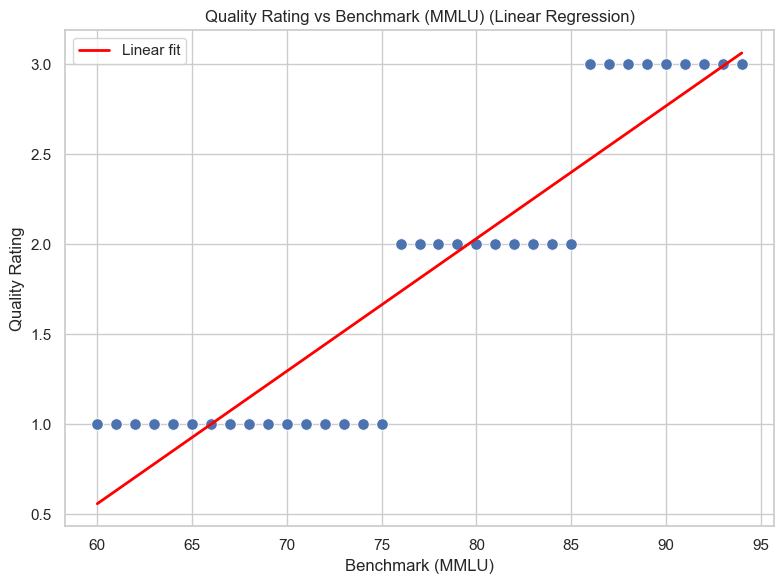

In [7]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=dxy[x_col], y=dxy[y_col], s=70)
xs = np.linspace(dxy[x_col].min(), dxy[x_col].max(), 100).reshape(-1, 1)
plt.plot(xs, lr.predict(xs), color='red', linewidth=2, label='Linear fit')
plt.title(f'{y_col} vs {x_col} (Linear Regression)')
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'linear_regression_plot.png', dpi=150)
plt.show()


## Tes Singkat (Sanity Test)

Tujuan tes:
- Memastikan jumlah prediksi sama dengan jumlah contoh uji.
- Memastikan metrik numerik dan nilai-nilai finite (bukan NaN atau inf).
- Memastikan nama fitur prediktor valid.


In [8]:
import math
assert y_pred.shape[0] == y_test.shape[0], 'Prediction length mismatch'
for k in ['MSE', 'RMSE', 'R2']:
    v = metrics[k]
    assert isinstance(v, (int, float)), f'Metric {k} non-numeric'
    assert math.isfinite(v), f'Metric {k} not finite'
assert isinstance(metrics['Predictor'], str) and metrics['Predictor'] in df.columns, 'Predictor name invalid'
print('Sanity test PASSED')


Sanity test PASSED


## Simpan Dataset Akhir (Bersih)

Menyimpan dataframe setelah pembersihan ringan ke `outputs/fully_analyzed_llm_data.csv`.


In [9]:
final_path = OUTPUT_DIR / 'fully_analyzed_llm_data.csv'
df.to_csv(final_path, index=False)
print(f'Final dataset saved to: {final_path}')


Final dataset saved to: outputs\fully_analyzed_llm_data.csv


## Output

In [13]:
# Linear Regression Metrics
metrics_df = pd.DataFrame([metrics])
print(metrics_df)


          Predictor          Target  Correlation       MSE      RMSE  \
0  Benchmark (MMLU)  Quality Rating     0.935881  0.078476  0.280136   

         R2  Coefficient  Intercept  
0  0.883631     0.073634  -3.858172  


In [14]:
# Correlation Summary
corr_df_sorted = corr_df.sort_values('abs_correlation', ascending=False)
print(corr_df_sorted)

                      feature  correlation  abs_correlation
3            Benchmark (MMLU)     0.935881         0.935881
4   Benchmark (Chatbot Arena)     0.132030         0.132030
1          Speed (tokens/sec)    -0.115062         0.115062
10               Speed Rating    -0.105168         0.105168
8               Compute Power     0.101301         0.101301
7       Training Dataset Size     0.091060         0.091060
11               Price Rating     0.086591         0.086591
5                 Open-Source     0.060012         0.060012
9           Energy Efficiency    -0.042873         0.042873
2               Latency (sec)    -0.016191         0.016191
0              Context Window     0.014796         0.014796
6      Price / Million Tokens    -0.010350         0.010350


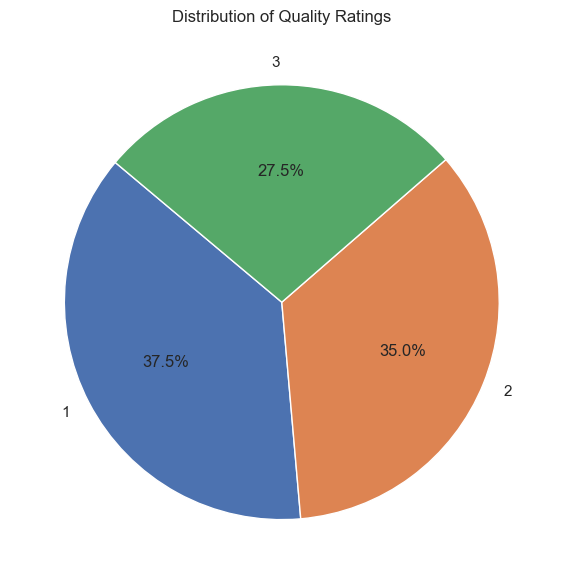

In [16]:
# Pie Chart of Rating Distribution
rating_counts = df[y_col].value_counts().sort_index()
plt.figure(figsize=(6,6))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Quality Ratings')
plt.tight_layout()
plt.show()

In [20]:
# Group By Data

grouped = df.groupby(y_col)[x_col].agg(['mean', 'median', 'count']).reset_index()
print(grouped)

   Quality Rating       mean  median  count
0               1  66.533333    67.0     75
1               2  80.671429    81.0     70
2               3  90.036364    90.0     55
